In [1]:
# previously named building_model_different_sizes.ipynb

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Setting the color palette
sns.color_palette('colorblind', n_colors=5)[1]

palette = {"Azhdam et al. (2020)":sns.color_palette('colorblind', n_colors=5)[0],
           "de Santana et al. (2021)":sns.color_palette('colorblind', n_colors=5)[1], 
           "Zhou et al. (2020) (pathological myopia)":sns.color_palette('colorblind', n_colors=5)[2],
           "Atchison et al. (2004)": sns.color_palette('colorblind', n_colors=5)[4]}

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Importing digitised data

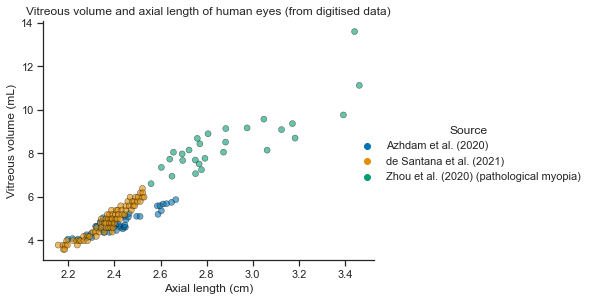

In [2]:
data_points_deSantana = pd.read_csv('../Data/digitised_data_deSantana2021.csv', names=['Axial length (cm)', 'Vitreous volume (mL)'])
data_points_deSantana['Source'] = 'de Santana et al. (2021)'
data_points_Zhou_myopic = pd.read_csv('../Data/digitised_data_Zhou2020_Fig1.csv', names = ['Axial length (cm)', 'Vitreous volume (mL)'])
data_points_Zhou_myopic['Source'] = 'Zhou et al. (2020) (pathological myopia)'
data_points_Azhdam = pd.read_csv('../Data/digitised_data_Azhdam2020.csv', names = ['Axial length (cm)', 'Vitreous volume (mL)'])
data_points_Azhdam['Source'] = 'Azhdam et al. (2020)'

df_data_tot = pd.concat([data_points_Azhdam, data_points_deSantana, data_points_Zhou_myopic])

sns.set_theme(style="ticks", font_scale=1)
g = sns.relplot(data=df_data_tot, x='Axial length (cm)', y='Vitreous volume (mL)', hue='Source', marker="o", alpha=0.6, edgecolor='black', palette=palette)
sns.move_legend(g, "center left", bbox_to_anchor=(0.556, 0.5))
plt.title('Vitreous volume and axial length of human eyes (from digitised data)')

g.figure.set_size_inches(10, 4)

## Building eye dimensions

In [3]:
# Methods to calculate dimensions

def volume_ellipsoid(vol_vit, lens_thick=0.3909, lens_diam=0.939):
    vol_lens = (4 * np.pi * (lens_thick/2) * (lens_diam/2)**2)/4
    return vol_vit + vol_lens

def calculate_b(axial_length, ACD=0.3276, lens_thick=0.3909):
    b = (axial_length - (ACD + lens_thick/2))/2
    return b

def get_a_from_vol_ell(vol_ellipsoid, b):
    a_squared = (3*vol_ellipsoid)/(4* np.pi*b)
    return np.sqrt(a_squared)

def calculate_a_b(axial_length, vol_vit, ACD=0.3276, lens_thick=0.3909, lens_diam=0.939):
    vol_ellipsoid = volume_ellipsoid(vol_vit, lens_thick, lens_diam)
    b = calculate_b(axial_length, ACD, lens_thick)
    a = get_a_from_vol_ell(vol_ellipsoid, b)
    return [a,b]

In [4]:
AL = df_data_tot["Axial length (cm)"].to_numpy()
vol_vit = df_data_tot["Vitreous volume (mL)"].to_numpy()
a_array = np.zeros(len(AL))
b_array = np.zeros(len(AL))

for i in range(0, len(AL)):
    [a, b] = calculate_a_b(AL[i], vol_vit[i])
    a_array[i] = a
    b_array[i] = b
    
df_data_tot["Semi-axis a (cm)"] = a_array
df_data_tot["Semi-axis b (cm)"] = b_array

#df_data_tot.to_csv("2023-10-19_digitised_data_model_measures.csv")

In [5]:
## Adding data from Atchison et al. (2004) (average from table)

def calculate_a_b_from_measures(axial_length, vit_diam, ACD=0.3276, lens_thick=0.3909):
    b = calculate_b(axial_length, ACD, lens_thick)
    a = vit_diam/2
    return [a,b]

def calculate_vol_vit(a, b, ACD=0.3276, lens_thick=0.3909,lens_diam=0.939):
    vol_ellipsoid = 4*np.pi*a**2*b/3
    vol_lens = (4 * np.pi * (lens_thick/2) * (lens_diam/2)**2)/4
    vol_vit = vol_ellipsoid - vol_lens
    return vol_vit


atchison_measures = [[2.31, 2.26], [2.39, 2.32],
                     [2.46, 2.35], [2.47, 2.32],
                     [2.47, 2.32], [2.47, 2.32],
                     [2.56, 2.37], [2.62, 2.41]]
# Obtained taking the mean of the two lengths for the AL, and the mean of the height and the width for the vitreous diameter

a_array_Atchison = np.zeros(len(atchison_measures))
b_array_Atchison = np.zeros(len(atchison_measures))
AL_array_Atchison = np.zeros(len(atchison_measures))
vol_vit_array_Atchison = np.zeros(len(atchison_measures))


for i in range(0, len(atchison_measures)):
    AL = atchison_measures[i][0]
    vit_diam = atchison_measures[i][1]
    [a,b] = calculate_a_b_from_measures(AL, vit_diam)
    vol_vit = calculate_vol_vit(a,b)
    a_array_Atchison[i] = a
    b_array_Atchison[i] = b
    AL_array_Atchison[i] = AL
    vol_vit_array_Atchison[i] = vol_vit

d_atch = {'Axial length (cm)':AL_array_Atchison,
          'Vitreous volume (mL)': vol_vit_array_Atchison,
          'Semi-axis a (cm)': a_array_Atchison,
          'Semi-axis b (cm)': b_array_Atchison}
df_atch = pd.DataFrame(data=d_atch)
df_atch["Source"] = "Atchison et al. (2004)"

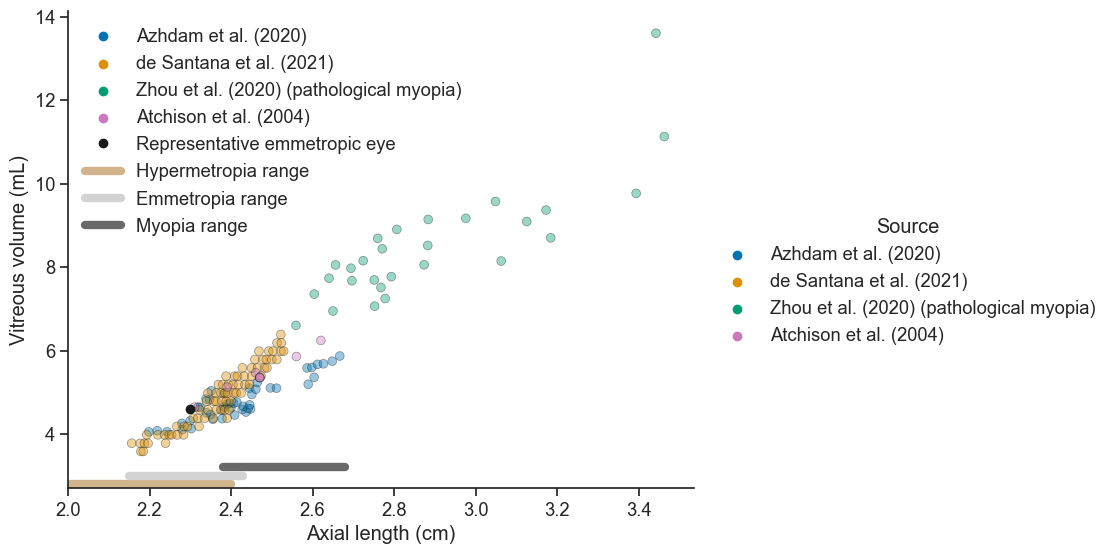

In [12]:
# Plotting the result

df_tot = pd.concat([df_data_tot, df_atch])
#df_tot.to_csv('Data/human_eyes_set_measures.csv', index=False)

sns.set_theme(style="ticks", font_scale=1.2)
sns.set_palette("colorblind")
g = sns.relplot(data=df_tot, x='Axial length (cm)', y='Vitreous volume (mL)', hue='Source', marker="o", alpha=0.4, edgecolor='black', palette=palette, s=40)
point = plt.plot(2.3, 4.5951, 'ko', label='Representative emmetropic eye')
hypemetropia = plt.plot([2.005, 2.4], [2.8, 2.8], lw=6, color='tan', linestyle='solid', label='Hypermetropia range', alpha=1, markersize=15)
emmetropia = plt.plot([2.15, 2.43], [3.0, 3.0], lw=6, color='lightgrey', linestyle='solid', label='Emmetropia range', alpha=1, markersize=15)
myopia = plt.plot([2.38, 2.68], [3.2, 3.2], lw=6, color='dimgrey', linestyle='solid', label='Myopia range', alpha=1, markersize=15)
plt.legend(frameon=False)
sns.move_legend(g, "center left", bbox_to_anchor=(0.556, 0.5))
#plt.title('Vitreous volume and axial length of human eyes')
plt.xlim(left=2.0)
plt.ylim(bottom=2.7)

g.figure.set_size_inches(16, 6)

#plt.savefig('../Figure4.pdf', format='pdf')
